In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import polars as pl
import gc


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/leap-atmospheric-physics-ai-climsim/sample_submission.csv
/kaggle/input/leap-atmospheric-physics-ai-climsim/train.csv
/kaggle/input/leap-atmospheric-physics-ai-climsim/test.csv
/kaggle/input/atmospred_mlp/pytorch/trained/1/best.pth


In [2]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# 读取数据
train_csv = '/kaggle/input/leap-atmospheric-physics-ai-climsim/train.csv'
test_csv = '/kaggle/input/leap-atmospheric-physics-ai-climsim/test.csv'
subm_spl = '/kaggle/input/leap-atmospheric-physics-ai-climsim/sample_submission.csv'
out_csv = 'submission.csv'

read_chunk_size = 100000 # 一次性读取100000行数据

# 训练参数
num_epochs = 0
max_patience = 3
batch_size = 360
num_workers = 256
lr = 0.0005

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
def graph(acc, loss, title):
    """ 绘制准确率和损失曲线

    Args:
        acc (list): [train, val]/[test]
        loss (list): [train, val]/[test]
        title (str): Title
    """
    assert len(acc) == len(loss), 'Length of acc and loss must be the same'
    global save_run_dir
    if len(acc) == 2:
        plt.subplot(1, 2, 1)
        plt.plot(acc[0], label='Training Accuracy')
        plt.plot(acc[1], label='Validation Accuracy')
        plt.title(title)
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(loss[0], label='Training Loss')
        plt.plot(loss[1], label='Validation Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
    elif len(acc) == 1:
        plt.subplot(2, 1, 1)
        plt.plot(acc[0], label='Test Accuracy')
        plt.title(title)
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        plt.subplot(2, 1, 2)
        plt.plot(loss[0], label='Test Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
    plt.show()

In [5]:
import time

class Timer:
    def __init__(self):
        self.t0 = 0
        self.t1 = 0
        self.times = []
        self.infos = []
        
    def start(self, info = 'Run'):
        self.t1 = self.t0
        self.infos.append(f'{len(self.infos)} {info}')
        self.t0 = time.time()
        
    def stop(self):
        self.t1 = time.time()
        t = self.t1 - self.t0
        self.times.append(t)
        print(f'{self.infos[-1]} Time Cost: {t:.3f}s')
        
    def get_stats(self):
        for info, tm in zip(self.infos, self.times):
            print(f'{info}\t{tm:.3f}s')
        print(f'Total: {sum(self.times):.3f} ')
    
    def clear(self, idx=0):
        if idx == 0:
            self.infos.clear()
            self.times.clear()
            return
        info = self.infos.pop(idx - (0 if idx < 0 else 1))
        tm = self.times.pop(idx - (0 if idx < 0 else 1))
        return info, tm
        
timer = Timer()

In [6]:
# 读取数据
timer.start(f'Read dataset chunk size {read_chunk_size}')
train_chunks = pd.read_csv(train_csv, chunksize = read_chunk_size)
train_data = next(train_chunks)
timer.stop()
# train_data = next(train_chunks)
# train_data = next(train_chunks)
cols = train_data.columns

train_data.shape

0 Read dataset chunk size 100000 Time Cost: 40.623s


(100000, 925)

# 划分数据集

1. 划分数据的输入输出
2. 划分 训练集，验证集(，测试集)

In [7]:
# 划分数据集

def split_io(dframe, in_cols = cols[1:557], out_cols = cols[557:]):
    # 划分输入输出
    in_df = dframe[in_cols]
    out_df = dframe[out_cols]
    return in_df, out_df

def split_tvt(dframe, ratio=[0.8], shuffle=False):
    # 设定好 train (和 val) 集的比例，剩余的均归到test/val
    assert sum(ratio) <= 1, "Ratio sum for train and val cannot be bigger than 1"
    assert len(ratio) > 0, "Ratio cannot be empty"
     # 根据是否需要测试集来调整比例
    train_rat = ratio[0]
    val_rat = (1 - train_rat) if len(ratio) == 1 else ratio[1]
    test_rat = (1 - train_rat - val_rat) if len(ratio) == 2 else 0
    
    data_size = dframe.shape[0]
    train_size = int(data_size * train_rat)
    val_size = (data_size - train_size) if len(ratio) == 1 else int(data_size * val_rat)
    
    if shuffle:
        dframe = dframe.sample(frac=1).reset_index(drop=True)
        
    train = dframe.iloc[:train_size]
    val = dframe.iloc[train_size:train_size + val_size]
    
    if test_rat != 0:
        test = dframe.iloc[train_size + val_size:]
        return train, val, test
    else:
        return train, val

In [8]:
# 划分数据集
train_set, val_set, test_set = split_tvt(train_data, [0.7, 0.2], True)
train_in, train_out = split_io(train_set)
val_in, val_out = split_io(val_set)
test_in, test_out = split_io(test_set)

print(f'{val_set.shape = }')
print(f'{test_set.shape = }')
print(f'{train_in.shape = }')
print(f'{train_out.shape = }')
print(f'{val_in.shape = }')
print(f'{val_out.shape = }')
# print(f'{val_out.iloc[0] = }')

del(train_data)
del(train_set)
del(val_set)
del(test_set)

val_set.shape = (20000, 925)
test_set.shape = (10000, 925)
train_in.shape = (70000, 556)
train_out.shape = (70000, 368)
val_in.shape = (20000, 556)
val_out.shape = (20000, 368)


In [9]:
class MLP_Dataset(Dataset):
    def __init__(self, dsin, dsout=None, test=False, transform = transforms.Compose([
        transforms.ToTensor(),
    ])):
        self.dsin = dsin
        self.test = test
        self.dsout = dsout
        self.transform =transform
    
    def __len__(self):
        return self.dsin.shape[0]
    
    def __getitem__(self, idx):
        data =  self.dsin.iloc[idx].to_numpy()
        data = torch.tensor(data).to(torch.float32).reshape((1, 556))
        if not self.test:
            targ = self.dsout.iloc[idx].to_numpy().reshape((1, 368))
            targ = torch.tensor(targ).to(torch.float32)
            return data, targ
        return data

In [10]:
train_dataset = MLP_Dataset(train_in, train_out)
print(f'{train_dataset[0][0].shape = } {train_dataset[0][1].shape = } {len(train_dataset) = }')
train_loader =  DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
print(f'{len(train_loader) = }')

val_dataset = MLP_Dataset(val_in, val_out)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
print(f'{len(val_loader) = }')

train_dataset[0][0].shape = torch.Size([1, 556]) train_dataset[0][1].shape = torch.Size([1, 368]) len(train_dataset) = 70000
len(train_loader) = 195
len(val_loader) = 56


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 256 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
def get_chunk_loader(chunk, test = False):
    tmr = Timer()
    tmr.start('Load datasets...')
    train_set, val_set = split_tvt(chunk)
    train_in, train_out = split_io(train_set)
    val_in, val_out = split_io(val_set)
    print(f'{train_in.shape = }')
    print(f'{train_out.shape = }')
    print(f'{val_in.shape = }')
    print(f'{val_out.shape = }')
    train_dataset = MLP_Dataset(train_in, train_out)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    print(f'{len(train_loader) = }')

    val_dataset = MLP_Dataset(val_in, val_out)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    print(f'{len(val_loader) = }')
    tmr.stop()
    return train_loader, val_loader

# Define MLP

In [12]:
def print_model(model, X):
    """打印出模型的每一层的输出形状

    Args:
        model (extend from nn.Module): 定义的模型
        X (tensor): 输入张量
    """
    for layer in model.children():
        X = layer(X)
        print("Layer: ", layer.__class__.__name__, "Output shape: ", X.shape)

class MLP(nn.Module):
    def __init__(self, layers=5, hidden=144):
        super(MLP, self).__init__()
        self.hidden = hidden
        self.linear = nn.Sequential(
            nn.Linear(556, hidden),
            nn.ReLU(),
            nn.Dropout(),
            *[nn.LazyLinear(hidden),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.Dropout(),] * (layers-2),
            nn.LazyLinear(368),
        )
    
    def forward(self, x):
        x = self.linear(x)
        return x

In [13]:
net = MLP(12, 512).to(device)
try:
    weights = torch.load('/kaggle/input/atmospred_mlp/pytorch/trained/1/best.pth', map_location=device)
    net.load_state_dict(weights)
    print("Weights loaded. ")
except:
    print("Weights not loaded. ")
print(net)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Weights loaded. 
MLP(
  (linear): Sequential(
    (0): Linear(in_features=556, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): LazyLinear(in_features=0, out_features=512, bias=True)
    (4): LazyBatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): LazyLinear(in_features=0, out_features=512, bias=True)
    (8): LazyBatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Dropout(p=0.5, inplace=False)
    (11): LazyLinear(in_features=0, out_features=512, bias=True)
    (12): LazyBatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
    (15): LazyLinear(in_features=0, out_features=512, bias=True)
    (16): LazyBatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (17): ReLU()
    (18): Dropout(p=0.5,

# Train Model

In [14]:
def r2score(pred, targ):
    targ_mean = torch.mean(targ)
    ss_total = torch.sum((targ - targ_mean) ** 2)
    ss_residual = torch.sum((targ - pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

criterion = nn.MSELoss()
    
optimizer = optim.Adam(net.parameters(), lr=lr)

In [15]:
lowest_loss = float('inf')

accus, losses = [[],[]], [[],[]]
epoch = 0
last_epoch = 0

Train End
0 Read dataset chunk size 100000 Time Cost: 42.292s


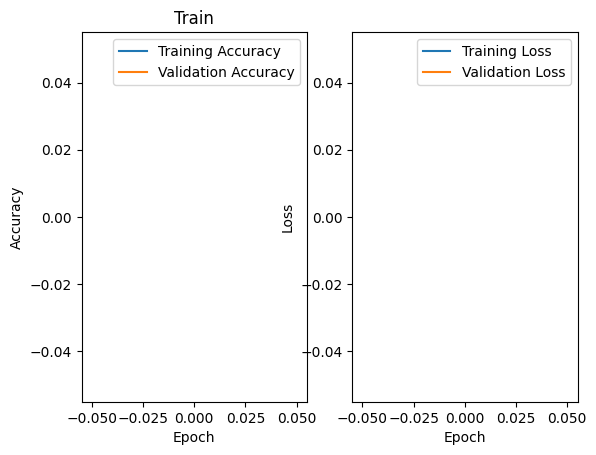

In [16]:
try:
    if num_epochs < 1:
        raise Exception()
    for idx, chunk in enumerate(train_chunks):
    # if True:
        patience = 0
        timer.start(f'Train {num_epochs} epochs on chunk {idx}')
        train_loader, val_loader = get_chunk_loader(chunk)
        while epoch < num_epochs:
            epoch += 1
            t0 = time.time()
            net.train()
            train_loss = 0.0
            train_accu = 0.0
            num_train_batches = 0

            for inp, outp in tqdm(train_loader):
                inp, outp = inp.to(device, non_blocking = True), outp.to(device, non_blocking = True)
                out_h = net(inp)
                crit = criterion(out_h, outp)
                loss = crit.item()
                train_loss += loss
                accu = r2score(out_h, outp)
                train_accu += accu
                crit.backward()
                optimizer.step()
                optimizer.zero_grad()
                num_train_batches += 1
            avg_train_loss = train_loss / num_train_batches
            losses[0].append(avg_train_loss)
            avg_train_accu = train_accu / num_train_batches
            accus[0].append(avg_train_accu.item())

            net.eval()
            val_loss = 0.0
            val_accu = 0.0
            num_val_batches = 0

            with torch.no_grad():
                for inp, outp in tqdm(val_loader):
    #                 inp, outp = [inps.to(device, non_blocking=True) for inps in inp], outp.cuda()
                    inp, outp = inp.to(device, non_blocking = True), outp.to(device, non_blocking = True)
                    out_h = net(inp)
                    crit = criterion(out_h, outp)
                    val_loss += crit.item()
                    accu = r2score(out_h, outp)
                    val_accu += accu
                    num_val_batches += 1
            try:
                last_val_loss = avg_val_loss
            except:
                last_val_loss = lowest_loss
            avg_val_loss = val_loss / num_val_batches
            losses[1].append(avg_val_loss)
            avg_val_accu = val_accu / num_val_batches
            accus[1].append(avg_val_accu.item())

            if avg_val_loss < lowest_loss:
                torch.save(net.state_dict(), 'best.pth')  # 保存模型参数而不是整个模型
                lowest_loss = avg_val_loss

            t1 = time.time()
            print(f'Chunk {idx}:{epoch - last_epoch} | Epoch {epoch}/{num_epochs} > Time Cost: {t1-t0:.2f}s | patience: {patience} \n\t', 
                  f'Train Loss: {avg_train_loss:.3f} | Val Loss: {avg_val_loss:.3f}\n\t',
                  f'Train Accu: {avg_train_accu:.3f} | Val Accu: {avg_val_accu:.3f}')
            if avg_train_loss < avg_val_loss and last_val_loss < avg_val_loss:
                patience += 1
            else:
                patience = 0
            if patience >= max_patience:
                print(f'{max_patience} epochs had val loss bigger than train loss and validation loss increased. Exit for next chunk of data')
                patience = 0
                last_epoch = epoch
                del(chunk)
                break
        else:
            print(f'Train End. {idx} chunks used. Trained {epoch} epochs. Lowest loss: {lowest_loss}')
            del(chunk)
            break
except:
    print('Train End')
timer.stop()
torch.save(net.state_dict(), "latest.pth") 
graph(accus, losses, 'Train')

In [17]:
# 清理
del(train_dataset)
del(train_loader)
del(val_dataset)
del(val_loader)

gc.collect()

6762

# Test Model

In [18]:
try:
    del(net)
    print('Latest net released!')
except:
    print('No model trained')

Latest net released!


In [19]:
net = MLP(12, 512).to(device)
# net.load_state_dict(torch.load('/kaggle/input/atmospred/pytorch/trained.pth/1/20240502-001.pth', map_location=device))
try:
    net.load_state_dict(torch.load('best.pth', map_location=device))
except:
    net.load_state_dict(torch.load('/kaggle/input/atmospred_mlp/pytorch/trained/1/best.pth', map_location=device))
print('Load best model.')

Load best model.


In [20]:
test_dataset = MLP_Dataset(test_in, test_out)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
print(f'{len(test_loader) = }')

len(test_loader) = 28


In [21]:
timer.start('Run Test')
net.eval()
test_loss = 0.0
test_accu = 0.0
num_test_batches = 0

with torch.no_grad():
    for i, (inp, outp) in enumerate(tqdm(test_loader)):
        inp, outp = inp.to(device, non_blocking=True), outp.to(device)
        out_h = net(inp)
        crit = criterion(out_h, outp)
        test_loss += crit.item()
        test_accu += r2score(out_h, outp)
        num_test_batches += 1

avg_test_loss = test_loss / num_test_batches
avg_test_accu = test_accu / num_test_batches

print(f'Test Loss: {avg_test_loss:.3f} | Test Accu: {avg_test_accu:.3f}')
timer.stop()

100%|██████████| 28/28 [00:09<00:00,  3.11it/s]

Test Loss: 110.002 | Test Accu: 0.840
1 Run Test Time Cost: 9.016s


In [22]:
# 清理变量
del(test_dataset)
del(test_loader)
del(out_h)
del(inp)
del(outp)

gc.collect()

90

# Submission

In [23]:
import polars as pl

timer.start('Read test csv dataset and submission sample')
subm_set = pl.read_csv(test_csv)
subm_multip = pl.read_csv(subm_spl)
timer.stop()
sample_cols = subm_multip.columns

2 Read test csv dataset and submission sample Time Cost: 43.244s


In [24]:
subm_multip.head(2)

sample_id,ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,ptend_t_9,ptend_t_10,ptend_t_11,ptend_t_12,ptend_t_13,ptend_t_14,ptend_t_15,ptend_t_16,ptend_t_17,ptend_t_18,ptend_t_19,ptend_t_20,ptend_t_21,ptend_t_22,ptend_t_23,ptend_t_24,ptend_t_25,ptend_t_26,ptend_t_27,ptend_t_28,ptend_t_29,ptend_t_30,ptend_t_31,ptend_t_32,ptend_t_33,ptend_t_34,ptend_t_35,…,ptend_v_31,ptend_v_32,ptend_v_33,ptend_v_34,ptend_v_35,ptend_v_36,ptend_v_37,ptend_v_38,ptend_v_39,ptend_v_40,ptend_v_41,ptend_v_42,ptend_v_43,ptend_v_44,ptend_v_45,ptend_v_46,ptend_v_47,ptend_v_48,ptend_v_49,ptend_v_50,ptend_v_51,ptend_v_52,ptend_v_53,ptend_v_54,ptend_v_55,ptend_v_56,ptend_v_57,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""test_169651""",30981.265272,22502.432414,18894.14713,14514.244731,10944.348069,9065.01072,9663.669039,12688.557363,19890.172265,25831.373172,33890.367562,44122.94111,59811.255951,79434.075001,107358.809169,135720.841835,149399.841111,128492.951853,91746.236873,72748.769111,66531.535968,62932.305984,56610.268743,49473.143692,43029.184954,36912.674919,31486.931179,26898.072997,23316.638283,20459.731332,18385.683096,17111.405108,16337.80992,15857.759882,15580.902485,15497.59046,…,122460.653992,132086.693875,141041.48571,146354.094413,145953.095901,139496.800789,128508.851082,116665.517697,107458.397063,100259.972367,94108.98505,88439.894562,82734.902766,77061.086214,71333.531924,65999.725321,61798.997206,58237.35642,54715.102663,50825.844317,46059.176887,40740.260504,36335.802283,33981.575686,33589.714339,33988.885241,36272.936451,41183.344137,29194.123693,0.004054,0.013882,1.3513e8,1.2220e7,0.009071,0.00859,0.021537,0.033632
"""test_524862""",30981.265272,22502.432414,18894.14713,14514.244731,10944.348069,9065.01072,9663.669039,12688.557363,19890.172265,25831.373172,33890.367562,44122.94111,59811.255951,79434.075001,107358.809169,135720.841835,149399.841111,128492.951853,91746.236873,72748.769111,66531.535968,62932.305984,56610.268743,49473.143692,43029.184954,36912.674919,31486.931179,26898.072997,23316.638283,20459.731332,18385.683096,17111.405108,16337.80992,15857.759882,15580.902485,15497.59046,…,122460.653992,132086.693875,141041.48571,146354.094413,145953.095901,139496.800789,128508.851082,116665.517697,107458.397063,100259.972367,94108.98505,88439.894562,82734.902766,77061.086214,71333.531924,65999.725321,61798.997206,58237.35642,54715.102663,50825.844317,46059.176887,40740.260504,36335.802283,33981.575686,33589.714339,33988.885241,36272.936451,41183.344137,29194.123693,0.004054,0.013882,1.3513e8,1.2220e7,0.009071,0.00859,0.021537,0.033632


In [25]:
insts = subm_set[subm_set.columns[0]]
subm_in = subm_set[subm_set.columns[1:]].to_pandas()
del(subm_set)
subm_in.shape

(625000, 556)

In [26]:
subm_dataset = MLP_Dataset(subm_in, test=True)
subm_loader = DataLoader(subm_dataset, batch_size = batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
print(f'{len(subm_loader) = }')
print(f'{subm_dataset[0].shape = }')
del(subm_in)
gc.collect()

len(subm_loader) = 1737
subm_dataset[0].shape = torch.Size([1, 556])


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 256 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


30

In [27]:
subm_multip = subm_multip.to_numpy()
subm_multip.shape, subm_multip[:, 0]

((625000, 369),
 array(['test_169651', 'test_524862', 'test_634129', ..., 'test_88942',
        'test_79382', 'test_601350'], dtype=object))

In [28]:
out_df = subm_multip[:, 1:].astype(float)
out_df = torch.tensor(out_df).to(device).to(torch.float32)
out_df.shape, out_df[1:4, 2:4]

(torch.Size([625000, 368]),
 tensor([[18894.1465, 14514.2451],
         [18894.1465, 14514.2451],
         [18894.1465, 14514.2451]], device='cuda:0'))

In [29]:
def convert_output(pred):
    """将输出张量转换为 dataframe 的 n 行"""
    pred = pred.squeeze(1)
    return pred

def postprocess(pred, scaler):
    pred = convert_output(pred)
    scaler *= pred
    return scaler

In [30]:
result = None
data_len = len(subm_loader)
print(f'Submission data lenth {data_len}')

Submission data lenth 1737


In [31]:
print(gc.collect())
timer.start('Get outputs')
with torch.no_grad():
    for i, smp in enumerate(subm_loader):
        t0 = time.time()
        smp =  smp.to(device, non_blocking=True)
#         print('smp to device', end='\r')
        scaler = out_df[i*batch_size:(i+1)*batch_size, :]
#         print('get scaler', end='\r')
        pred = net(smp)
#         print('infer', end='\r')
        scaler = postprocess(pred, scaler)
#         print('post process', end='\r')
        if i == 0:
            result = scaler
        else:
            result = torch.cat((result, scaler), axis=0)
        print(f'[{"=" * int(25 * i / data_len)}{"C" if i % 2 == 0 else "c"}{"-" * (25 - int(25 * i / data_len))}] Batch {i}/{data_len} > {result.shape = } | {1 / (time.time() - t0):.2f}it/s', end='\r')
    print('\n')
print(f'Batch {i} > {result.shape = } | ')
timer.stop()

0
[========================C-] Batch 1736/1737 > result.shape = torch.Size([625000, 368]) | 129.75it/s

Batch 1736 > result.shape = torch.Size([625000, 368]) | 
3 Get outputs Time Cost: 93.410s


In [32]:
result = result.to('cpu').detach().numpy()
result.shape, result.dtype

((625000, 368), dtype('float32'))

In [33]:
sample_ids = pl.from_numpy(subm_multip[:, 0].reshape(-1 ,1))
sample_ids.columns = sample_cols[0:1]
sample_prs = pl.from_numpy(result)
sample_prs.columns = sample_cols[1:]
del(subm_multip)
sample_ids.head(2), sample_prs.head(2)

(shape: (2, 1)
 ┌─────────────┐
 │ sample_id   │
 │ ---         │
 │ str         │
 ╞═════════════╡
 │ test_169651 │
 │ test_524862 │
 └─────────────┘,
 shape: (2, 368)
 ┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
 │ ptend_t_0 ┆ ptend_t_1 ┆ ptend_t_2 ┆ ptend_t_3 ┆ … ┆ cam_out_S ┆ cam_out_S ┆ cam_out_S ┆ cam_out_ │
 │ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ OLS       ┆ OLL       ┆ OLSD      ┆ SOLLD    │
 │ f32       ┆ f32       ┆ f32       ┆ f32       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
 │           ┆           ┆           ┆           ┆   ┆ f32       ┆ f32       ┆ f32       ┆ f32      │
 ╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
 │ 112.92030 ┆ 80.728722 ┆ -113.7368 ┆ 73.368103 ┆ … ┆ 0.037648  ┆ 0.059808  ┆ 0.190383  ┆ 0.180304 │
 │ 3         ┆           ┆ 16        ┆           ┆   ┆           ┆           ┆           ┆          │
 │ 112.92030 ┆ 

In [34]:
# save_data = pl.from_numpy(data)
save_save = pl.concat([sample_ids, sample_prs], how = "horizontal")
save_save.head(2)

sample_id,ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,ptend_t_9,ptend_t_10,ptend_t_11,ptend_t_12,ptend_t_13,ptend_t_14,ptend_t_15,ptend_t_16,ptend_t_17,ptend_t_18,ptend_t_19,ptend_t_20,ptend_t_21,ptend_t_22,ptend_t_23,ptend_t_24,ptend_t_25,ptend_t_26,ptend_t_27,ptend_t_28,ptend_t_29,ptend_t_30,ptend_t_31,ptend_t_32,ptend_t_33,ptend_t_34,ptend_t_35,…,ptend_v_31,ptend_v_32,ptend_v_33,ptend_v_34,ptend_v_35,ptend_v_36,ptend_v_37,ptend_v_38,ptend_v_39,ptend_v_40,ptend_v_41,ptend_v_42,ptend_v_43,ptend_v_44,ptend_v_45,ptend_v_46,ptend_v_47,ptend_v_48,ptend_v_49,ptend_v_50,ptend_v_51,ptend_v_52,ptend_v_53,ptend_v_54,ptend_v_55,ptend_v_56,ptend_v_57,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""test_169651""",112.920303,80.728722,-113.736816,73.368103,-30.201014,63.477821,9.353407,-66.842735,-0.541982,11.8318,-88.711487,424.837982,-71.256363,0.560301,181.282074,-54.115799,-34.324875,-848.990417,-22.3484,-68.151688,63.91415,-486.693054,100.571312,-136.417831,-11.996836,-275.693604,104.745262,169.752319,-186.880371,14.552244,-4.014626,0.019091,-3.225091,37.473473,-11.197102,-52.659477,…,155.800507,-50.840015,-767.394348,-240.498611,-1420.261719,169.228607,-28.509872,-9.368064,-579.744629,-3.054083,-248.271652,379.987427,-1546.053833,628.511719,-260.023407,-703.984619,354.391266,-81.9114,-72.10482,-229.82959,1.941056,102.760414,89.669655,5.985535,50.80135,-308.407623,-55.285816,-149.807037,224.280426,0.06623,3.89297,-37807.363281,-14500.273438,0.037648,0.059808,0.190383,0.180304
"""test_524862""",112.920303,80.728722,-113.736816,73.368103,-30.201014,63.477821,9.353407,-66.842735,-0.541982,11.8318,-88.711487,424.837982,-71.256363,0.560301,181.282074,-54.115799,-34.324875,-848.990417,-22.3484,-68.151688,63.91415,-486.693054,100.571312,-136.417831,-11.996836,-275.693604,104.745262,169.752319,-186.880371,14.552244,-4.014626,0.019091,-3.225091,37.473473,-11.197102,-52.659477,…,155.800507,-50.840015,-767.394348,-240.498611,-1420.261719,169.228607,-28.509872,-9.368064,-579.744629,-3.054083,-248.271652,379.987427,-1546.053833,628.511719,-260.023407,-703.984619,354.391266,-81.9114,-72.10482,-229.82959,1.941056,102.760414,89.669655,5.985535,50.80135,-308.407623,-55.285816,-149.807037,224.280426,0.06623,3.89297,-37807.363281,-14500.273438,0.037648,0.059808,0.190383,0.180304


In [35]:
save_save.write_csv(out_csv)

In [36]:
save_save.shape

(625000, 369)